In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import numpy as np
from sklearn.cluster import HDBSCAN
import random
from tqdm import tqdm
# from lib.dataloader import CustomTestDataset
from boilerplate.dataloader import CustomTestDataset
import tifffile as tiff
import os
from boilerplate import boilerplate
from scipy.spatial.distance import cdist
from torch.nn.functional import unfold
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dist_metric = ['cosine']

num_clusters = 4
patch_size = (64,64)
mask_size = 5
label_size = 5
n_channel = 32
hierarchy_level = 3

In [3]:
data_dir = "/group/jug/Sheida/pancreatic beta cells/download/"

One_test_image = ['high_c4']

# Load test image
test_img_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_source.tif")
test_images = tiff.imread(test_img_path)

# Print loaded test images paths
print("Test image loaded from path:")
print(test_img_path)

# Load test ground truth images
test_gt_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_gt.tif")
test_ground_truth_image = tiff.imread(test_gt_path)

Test image loaded from path:
/group/jug/Sheida/pancreatic beta cells/download/high_c4/high_c4_source.tif


In [4]:
def count_label_pixels(ground_truth):
    # Get unique labels and their counts
    unique_labels, counts = np.unique(ground_truth, return_counts=True)
    
    # Create a dictionary to store label-wise pixel counts
    label_pixel_counts = dict(zip(unique_labels, counts))
    
    return label_pixel_counts

In [5]:
label_pixel_counts = count_label_pixels(test_ground_truth_image)
print(f"Label-wise pixel counts:{label_pixel_counts}")

Label-wise pixel counts:{-1: 409001638, 0: 107710351, 1: 25910981, 2: 36936035, 3: 23104175}


In [6]:
def select_random_pixels_within_range(ground_truth, labels, pixels_per_class, x_range, y_range, z_range):
    selected_pixels = {}

    for label in labels:
        # Get the coordinates where ground truth equals the label
        coords = np.argwhere(ground_truth == label)
        
        # Filter coordinates based on the specified range
        x_in_range = (coords[:, 2] >= x_range[0]) & (coords[:, 2] <= x_range[1])
        y_in_range = (coords[:, 1] >= y_range[0]) & (coords[:, 1] <= y_range[1])
        z_in_range = (coords[:, 0] >= z_range[0]) & (coords[:, 0] <= z_range[1])
        
        # Keep only the coordinates that satisfy all range conditions
        filtered_coords = coords[z_in_range & y_in_range & x_in_range]
        
        # Check if there are enough pixels for the current label after filtering
        if len(filtered_coords) < pixels_per_class:
            raise ValueError(f"Not enough pixels for label {label} within the specified range. Found {len(filtered_coords)}, required {pixels_per_class}")
        
        # Randomly select pixels_per_class coordinates from filtered_coords
        chosen_indices = np.random.choice(len(filtered_coords), pixels_per_class, replace=False)
        chosen_coords = filtered_coords[chosen_indices]
        
        # Store selected coordinates for the label
        selected_pixels[label] = chosen_coords

    return selected_pixels


In [7]:
labels_of_interest = [0, 1, 2, 3]
z, y, x = test_images.shape
x_range = (32, x - 32)
y_range = (32, y - 32)
z_range = (0, z - 1)

In [8]:
selected_pixel_coords = select_random_pixels_within_range(test_ground_truth_image, labels_of_interest, pixels_per_class=256, x_range=x_range, y_range=y_range, z_range=z_range)

In [9]:
for label, coords in selected_pixel_coords.items():
    print(f"Label {label}: {coords}")

Label 0: [[ 753  217  399]
 [ 588  418  440]
 [ 446   76  810]
 [ 344  307  929]
 [ 574  228  687]
 [ 688  442  985]
 [ 848  394  464]
 [ 575  194  302]
 [ 659  308  186]
 [ 883  404  615]
 [ 314  423  471]
 [ 374   99  670]
 [ 839  315  877]
 [ 714  286   99]
 [ 676  102  617]
 [ 550  417  389]
 [ 760  330  623]
 [ 606  436  479]
 [ 654  173  720]
 [ 315  137  447]
 [ 372  247  897]
 [ 686  218  731]
 [ 833  285   97]
 [ 403  151  414]
 [ 805  221  570]
 [ 481  500  541]
 [ 525  167  625]
 [ 835  394  559]
 [ 196  228  897]
 [ 737  300  730]
 [ 438  191  944]
 [ 589  363  427]
 [ 490  244  887]
 [ 363  255  241]
 [ 651  435  277]
 [ 796  203  277]
 [ 785  194  441]
 [ 208  155 1011]
 [ 472  175  630]
 [ 339  232  470]
 [ 429  204  954]
 [ 893  390  407]
 [ 756  229  682]
 [ 325  285  371]
 [ 272  351  950]
 [ 860  343  878]
 [ 584  170  820]
 [ 466  238  737]
 [ 857  254  149]
 [ 330  360  852]
 [ 780  264  537]
 [ 539  380  408]
 [ 548  135  785]
 [ 410   85  695]
 [ 726  262  153]
 

In [10]:
import pickle

def save_as_pickle(selected_pixel_coords, filename):
    with open(filename, 'wb') as f:
        pickle.dump(selected_pixel_coords, f)

# Usage
save_as_pickle(selected_pixel_coords, 'selected_pixel_coords.pkl')

In [11]:
def extract_patches(image, coords, patch_size=(64,64)):
    half_size_y = patch_size[0] // 2
    half_size_x = patch_size[1] // 2
    patches = []

    # Get the shape of the image
    _, y_max, x_max = image.shape

    for coord in coords:
        z, y, x = coord

        # Calculate the boundaries of the patch
        x_start = max(0, x - half_size_x)
        x_end = min(x_max, x + half_size_x)
        y_start = max(0, y - half_size_y)
        y_end = min(y_max, y + half_size_y)

        
        # Extract the patch from the image
        patch = image[z, y_start:y_end, x_start:x_end]
        
        # Check if the patch is the required size, otherwise pad with zeros
        if patch.shape != patch_size:
            print("something is wrong")

        
        # Store the patch
        patches.append(patch)

    return np.array(patches)

In [12]:
all_patches_tensors = []

for label, coords in selected_pixel_coords.items():
    patches = extract_patches(test_images, coords, patch_size=patch_size)
    patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)
    print(f"Patches for label {label}: {patches_tensor.shape}")  # The shape should be (256, 64, 64)
    all_patches_tensors.append(patches_tensor)

combined_tensor = torch.stack(all_patches_tensors, dim=0).reshape(8, 128, 1, 64, 64)
print(combined_tensor.shape)

Patches for label 0: torch.Size([256, 1, 64, 64])
Patches for label 1: torch.Size([256, 1, 64, 64])
Patches for label 2: torch.Size([256, 1, 64, 64])
Patches for label 3: torch.Size([256, 1, 64, 64])
torch.Size([8, 128, 1, 64, 64])


In [13]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['5x5_5x5', '5x5_3x3', '3x3_3x3', '5x5_1x1', '3x3_1x1', '1x1_1x1']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'supervised_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}supervised_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.28it/s]


In [14]:
seg = []
for i in range(len(model_versions)):
    seg.append(tiff.imread(f"{model_dir}supervised_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(seg[i][j]))

{1: 245, 2: 9, 3: 2}
{0: 242, 1: 14}
{1: 91, 2: 163, 3: 2}
{1: 137, 2: 2, 3: 117}
{0: 1, 1: 242, 2: 11, 3: 2}
{0: 248, 1: 8}
{1: 53, 2: 201, 3: 2}
{1: 116, 2: 4, 3: 136}
{0: 1, 1: 236, 2: 12, 3: 7}
{0: 241, 1: 15}
{1: 56, 2: 198, 3: 2}
{1: 110, 2: 2, 3: 144}
{0: 4, 1: 16, 2: 213, 3: 23}
{0: 253, 2: 3}
{1: 197, 2: 57, 3: 2}
{1: 2, 2: 90, 3: 164}
{0: 5, 1: 15, 2: 220, 3: 16}
{0: 251, 2: 4, 3: 1}
{0: 1, 1: 206, 2: 39, 3: 10}
{1: 3, 2: 110, 3: 143}
{0: 4, 1: 18, 2: 220, 3: 14}
{0: 245, 2: 11}
{0: 1, 1: 5, 2: 53, 3: 197}
{1: 197, 2: 55, 3: 4}


In [15]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def compute_dice_coefficient(ground_truth, predicted):
    """
    Compute Dice coefficient between ground truth and predicted segmentation after resolving label permutations.
    
    Args:
    - ground_truth (numpy array): Ground truth labels (values from 0 to 3).
    - predicted (numpy array): Predicted labels (after clustering, might be permuted).
    
    Returns:
    - dice_coefficients (list): Dice coefficients for each class (label).
    """
    # Ensure both arrays are 1D
    ground_truth = ground_truth.flatten()
    predicted = predicted.flatten()
    
    # Create a confusion matrix
    # Rows: Ground truth labels (0 to 3)
    # Columns: Predicted cluster labels (0 to 3, possibly permuted)
    conf_matrix = confusion_matrix(ground_truth, predicted, labels=[0, 1, 2, 3])
    
    # Use the Hungarian algorithm to find the optimal label assignment (best permutation)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)  # Negative because it's maximization problem
    
    # Re-map predicted labels to match ground truth
    remapped_predicted = np.zeros_like(predicted)
    for gt_label, pred_label in zip(row_ind, col_ind):
        remapped_predicted[predicted == pred_label] = gt_label
    
    # Compute Dice coefficient for each class
    dice_coefficients = []
    for label in np.unique(ground_truth):
        gt_binary = (ground_truth == label)
        pred_binary = (remapped_predicted == label)
        
        intersection = np.sum(gt_binary & pred_binary)
        dice = (2. * intersection) / (np.sum(gt_binary) + np.sum(pred_binary))
        dice_coefficients.append(dice)
    
    return dice_coefficients

In [16]:
gt = np.zeros((4, 256), dtype=np.uint8)
gt[0] = 0
gt[1] = 1
gt[2] = 2
gt[3] = 3

In [17]:
for i in range(len(seg)):
    dice_scores = compute_dice_coefficient(gt, seg[i])
    print(f"Model version supervised {model_versions[i]}:")
    print(dice_scores)

Model version supervised 5x5_5x5:
[0.6594885598923284, 0.9718875502008032, 0.7581395348837209, 0.6206896551724138]
Model version supervised 5x5_3x3:
[0.717037037037037, 0.9821782178217822, 0.8516949152542372, 0.6868686868686869]
Model version supervised 3x3_3x3:
[0.7013372956909361, 0.9678714859437751, 0.8461538461538461, 0.7041564792176039]
Model version supervised 5x5_1x1:
[0.6882067851373183, 0.98635477582846, 0.8365180467091295, 0.7370786516853932]
Model version supervised 3x3_1x1:
[0.699523052464229, 0.9785575048732943, 0.8583333333333333, 0.6713615023474179]
Model version supervised 1x1_1x1:
[0.7394957983193278, 0.9683794466403162, 0.8365180467091295, 0.8277310924369747]


In [18]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['5x5_5x5', '5x5_3x3', '3x3_3x3', '5x5_1x1', '3x3_1x1', '1x1_1x1']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'10p_semi_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}10p_semi_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


In [19]:
semi_10_seg = []
for i in range(len(model_versions)):
    semi_10_seg.append(tiff.imread(f"{model_dir}10p_semi_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(semi_10_seg[i][j]))

{1: 253, 2: 2, 3: 1}
{0: 229, 1: 27}
{1: 242, 3: 14}
{1: 231, 2: 25}
{0: 1, 1: 238, 2: 12, 3: 5}
{0: 233, 1: 23}
{1: 120, 2: 136}
{1: 180, 2: 2, 3: 74}
{1: 245, 2: 5, 3: 6}
{0: 213, 1: 43}
{1: 121, 2: 133, 3: 2}
{1: 118, 2: 7, 3: 131}
{0: 3, 1: 231, 2: 18, 3: 4}
{0: 248, 1: 8}
{1: 89, 2: 165, 3: 2}
{0: 1, 1: 119, 2: 5, 3: 131}
{1: 232, 2: 11, 3: 13}
{0: 238, 1: 16, 2: 1, 3: 1}
{1: 98, 2: 153, 3: 5}
{1: 126, 2: 5, 3: 125}
{0: 2, 1: 223, 2: 17, 3: 14}
{0: 241, 1: 13, 2: 2}
{1: 80, 2: 6, 3: 170}
{1: 46, 2: 205, 3: 5}


In [20]:
for i in range(len(semi_10_seg)):
    dice_scores = compute_dice_coefficient(gt, semi_10_seg[i])
    print(f"Model version SS 10% {model_versions[i]}:")
    print(dice_scores)

Model version SS 10% 5x5_5x5:
[0.5014866204162537, 0.9443298969072165, 0.1033210332103321, 0.17667844522968199]
Model version SS 10% 5x5_3x3:
[0.5826193390452876, 0.9510204081632653, 0.6699507389162561, 0.4417910447761194]
Model version SS 10% 3x3_3x3:
[0.6257982120051085, 0.908315565031983, 0.6633416458852868, 0.6632911392405063]
Model version SS 10% 5x5_1x1:
[0.6571834992887624, 0.9763779527559056, 0.7432432432432432, 0.6666666666666666]
Model version SS 10% 3x3_1x1:
[0.6373626373626373, 0.9635627530364372, 0.7183098591549296, 0.625]
Model version SS 10% 1x1_1x1:
[0.7216828478964401, 0.9659318637274549, 0.7640449438202247, 0.8436213991769548]


In [21]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['5x5_5x5', '5x5_3x3', '3x3_3x3', '5x5_1x1', '3x3_1x1', '1x1_1x1']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'1p_semi_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}1p_semi_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


In [22]:
semi_1_seg = []
for i in range(len(model_versions)):
    semi_1_seg.append(tiff.imread(f"{model_dir}1p_semi_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(semi_1_seg[i][j]))

{0: 2, 1: 246, 2: 7, 3: 1}
{0: 183, 1: 42, 2: 31}
{1: 247, 3: 9}
{0: 6, 1: 227, 2: 20, 3: 3}
{1: 1, 2: 248, 3: 7}
{0: 177, 1: 56, 2: 23}
{2: 232, 3: 24}
{2: 215, 3: 41}
{0: 3, 1: 225, 2: 11, 3: 17}
{0: 244, 1: 12}
{1: 203, 2: 3, 3: 50}
{0: 2, 1: 178, 2: 63, 3: 13}
{1: 195, 2: 20, 3: 41}
{0: 202, 1: 30, 2: 16, 3: 8}
{1: 182, 2: 32, 3: 42}
{1: 192, 2: 20, 3: 44}
{0: 1, 1: 183, 2: 57, 3: 15}
{0: 207, 1: 16, 2: 1, 3: 32}
{1: 161, 2: 89, 3: 6}
{0: 1, 1: 155, 2: 48, 3: 52}
{1: 52, 2: 198, 3: 6}
{0: 205, 2: 46, 3: 5}
{1: 94, 2: 160, 3: 2}
{1: 81, 2: 96, 3: 79}


In [23]:
for i in range(len(semi_1_seg)):
    dice_scores = compute_dice_coefficient(gt, semi_1_seg[i])
    print(f"Model version SS 1% {model_versions[i]}:")
    print(dice_scores)

Model version SS 1% 5x5_5x5:
[0.48330058939096265, 0.8187919463087249, 0.06691449814126393, 0.12738853503184713]
Model version SS 1% 5x5_3x3:
[0.5092402464065708, 0.8175519630484989, 0.0, 0.25]
Model version SS 1% 3x3_3x3:
[0.5148741418764302, 0.9663366336633663, 0.2976190476190476, 0.3783783783783784]
Model version SS 1% 5x5_1x1:
[0.45614035087719296, 0.8820960698689956, 0.18604651162790697, 0.22506393861892582]
Model version SS 1% 3x3_1x1:
[0.47470817120622566, 0.8903225806451613, 0.3946784922394678, 0.2880886426592798]
Model version SS 1% 1x1_1x1:
[0.5238095238095238, 0.8893709327548807, 0.38923395445134573, 0.4540229885057471]


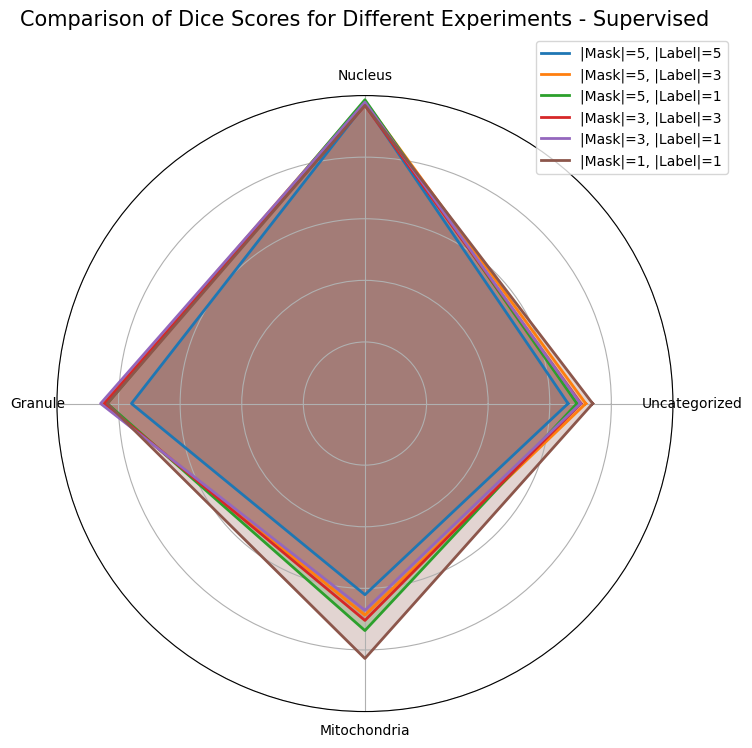

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments - Supervised', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
    [0.6594885598923284, 0.9718875502008032, 0.7581395348837209, 0.6206896551724138],
    [0.717037037037037, 0.9821782178217822, 0.8516949152542372, 0.6868686868686869],
    [0.6882067851373183, 0.98635477582846, 0.8365180467091295, 0.7370786516853932],
    [0.7013372956909361, 0.9678714859437751, 0.8461538461538461, 0.7041564792176039],
    [0.699523052464229, 0.9785575048732943, 0.8583333333333333, 0.6713615023474179],
    [0.7394957983193278, 0.9683794466403162, 0.8365180467091295, 0.8277310924369747]
]
experiment_labels = ['|Mask|=5, |Label|=5', '|Mask|=5, |Label|=3', '|Mask|=5, |Label|=1', '|Mask|=3, |Label|=3', '|Mask|=3, |Label|=1', '|Mask|=1, |Label|=1']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


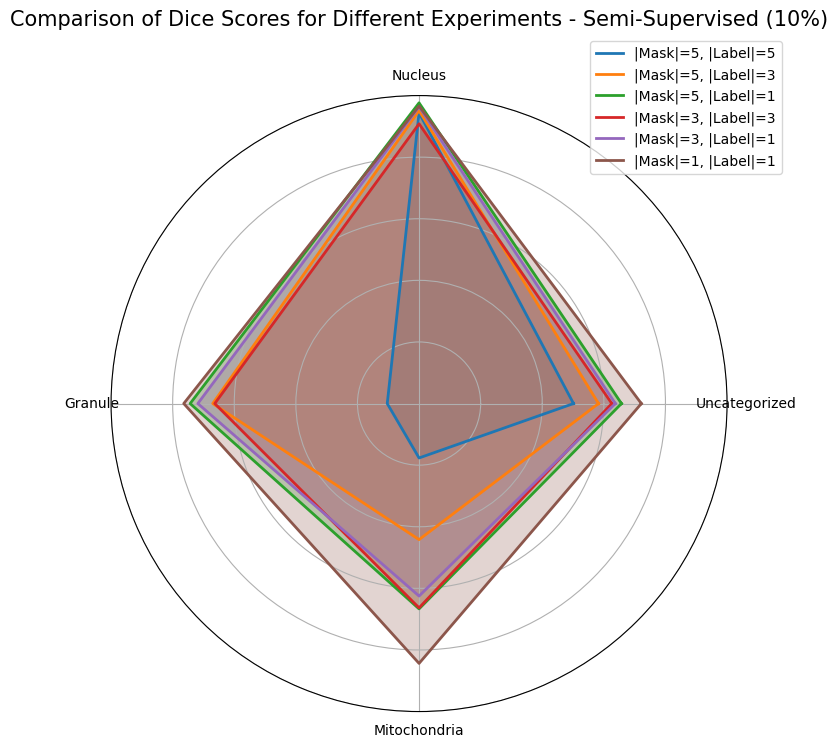

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments - Semi-Supervised (10%)', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
    [0.5014866204162537, 0.9443298969072165, 0.1033210332103321, 0.17667844522968199],
    [0.5826193390452876, 0.9510204081632653, 0.6699507389162561, 0.4417910447761194],
    [0.6571834992887624, 0.9763779527559056, 0.7432432432432432, 0.6666666666666666],
    [0.6257982120051085, 0.908315565031983, 0.6633416458852868, 0.6632911392405063],
    [0.6373626373626373, 0.9635627530364372, 0.7183098591549296, 0.625],
    [0.7216828478964401, 0.9659318637274549, 0.7640449438202247, 0.8436213991769548]
]
experiment_labels = ['|Mask|=5, |Label|=5', '|Mask|=5, |Label|=3', '|Mask|=5, |Label|=1', '|Mask|=3, |Label|=3', '|Mask|=3, |Label|=1', '|Mask|=1, |Label|=1']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


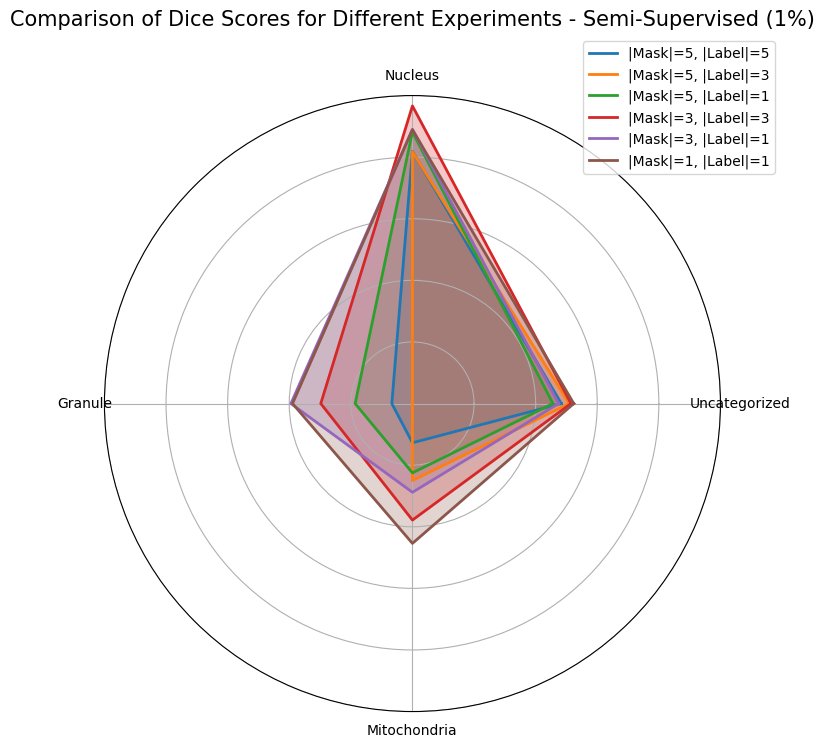

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments - Semi-Supervised (1%)', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.48330058939096265, 0.8187919463087249, 0.06691449814126393, 0.12738853503184713],
[0.5092402464065708, 0.8175519630484989, 0.0, 0.25],
[0.45614035087719296, 0.8820960698689956, 0.18604651162790697, 0.22506393861892582],
[0.5148741418764302, 0.9663366336633663, 0.2976190476190476, 0.3783783783783784],
[0.47470817120622566, 0.8903225806451613, 0.3946784922394678, 0.2880886426592798],
[0.5238095238095238, 0.8893709327548807, 0.38923395445134573, 0.4540229885057471]]
experiment_labels = ['|Mask|=5, |Label|=5', '|Mask|=5, |Label|=3', '|Mask|=5, |Label|=1', '|Mask|=3, |Label|=3', '|Mask|=3, |Label|=1', '|Mask|=1, |Label|=1']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


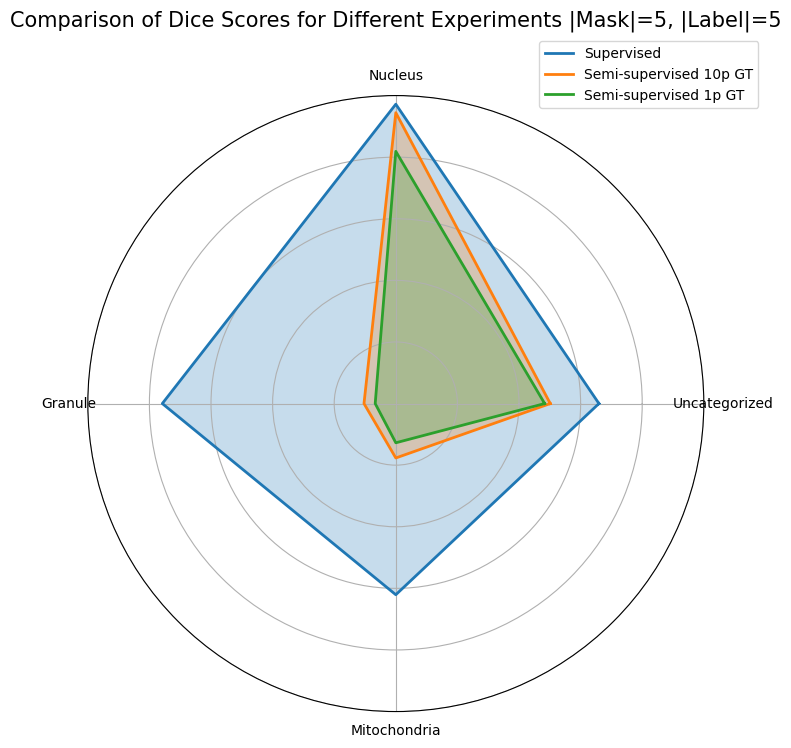

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments |Mask|=5, |Label|=5', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.6594885598923284, 0.9718875502008032, 0.7581395348837209, 0.6206896551724138],
[0.5014866204162537, 0.9443298969072165, 0.1033210332103321, 0.17667844522968199],
[0.48330058939096265, 0.8187919463087249, 0.06691449814126393, 0.12738853503184713]
]
experiment_labels = ['Supervised', 'Semi-supervised 10p GT', 'Semi-supervised 1p GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


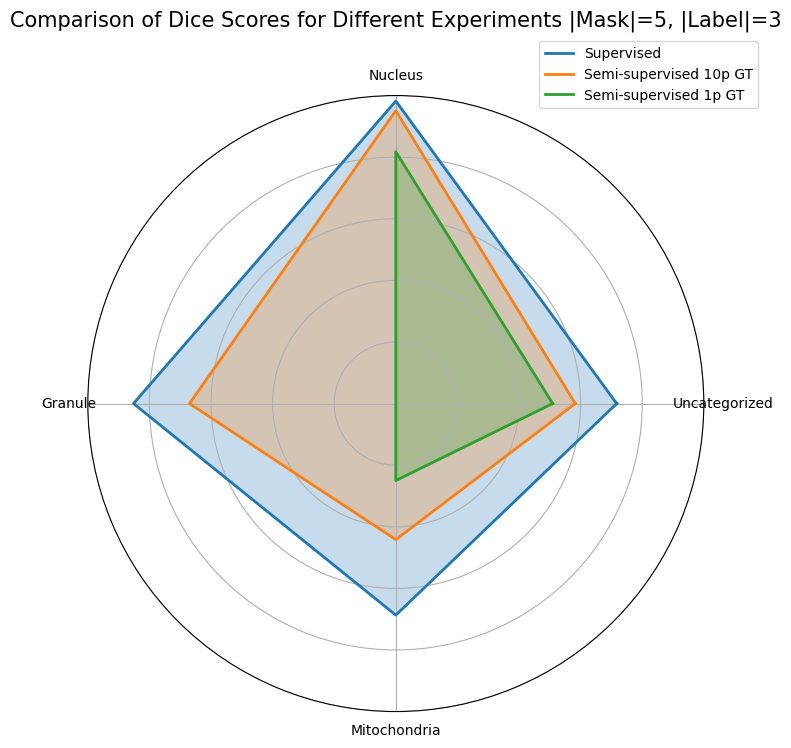

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments |Mask|=5, |Label|=3', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.717037037037037, 0.9821782178217822, 0.8516949152542372, 0.6868686868686869],
[0.5826193390452876, 0.9510204081632653, 0.6699507389162561, 0.4417910447761194],
[0.5092402464065708, 0.8175519630484989, 0.0, 0.25]
]
experiment_labels = ['Supervised', 'Semi-supervised 10p GT', 'Semi-supervised 1p GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


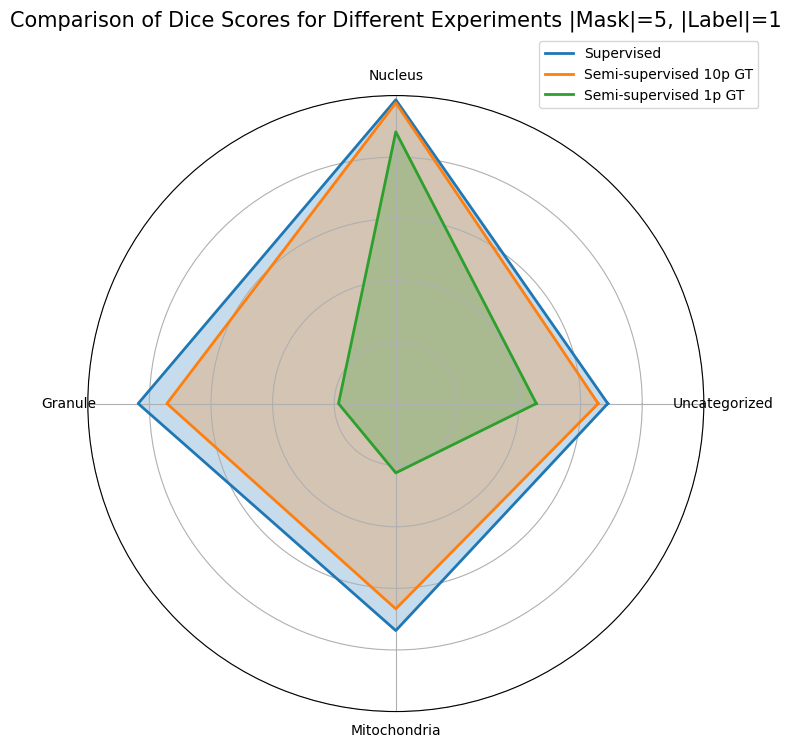

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments |Mask|=5, |Label|=1', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.6882067851373183, 0.98635477582846, 0.8365180467091295, 0.7370786516853932],
[0.6571834992887624, 0.9763779527559056, 0.7432432432432432, 0.6666666666666666],
[0.45614035087719296, 0.8820960698689956, 0.18604651162790697, 0.22506393861892582]
]
experiment_labels = ['Supervised', 'Semi-supervised 10p GT', 'Semi-supervised 1p GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


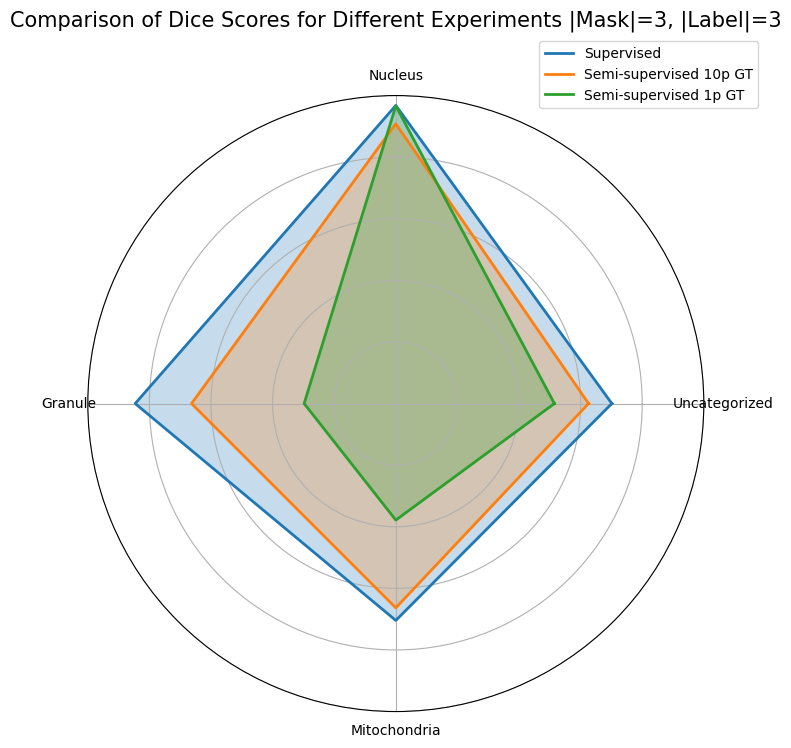

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments |Mask|=3, |Label|=3', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.7013372956909361, 0.9678714859437751, 0.8461538461538461, 0.7041564792176039],
[0.6257982120051085, 0.908315565031983, 0.6633416458852868, 0.6632911392405063],
[0.5148741418764302, 0.9663366336633663, 0.2976190476190476, 0.3783783783783784]
]
experiment_labels = ['Supervised', 'Semi-supervised 10p GT', 'Semi-supervised 1p GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


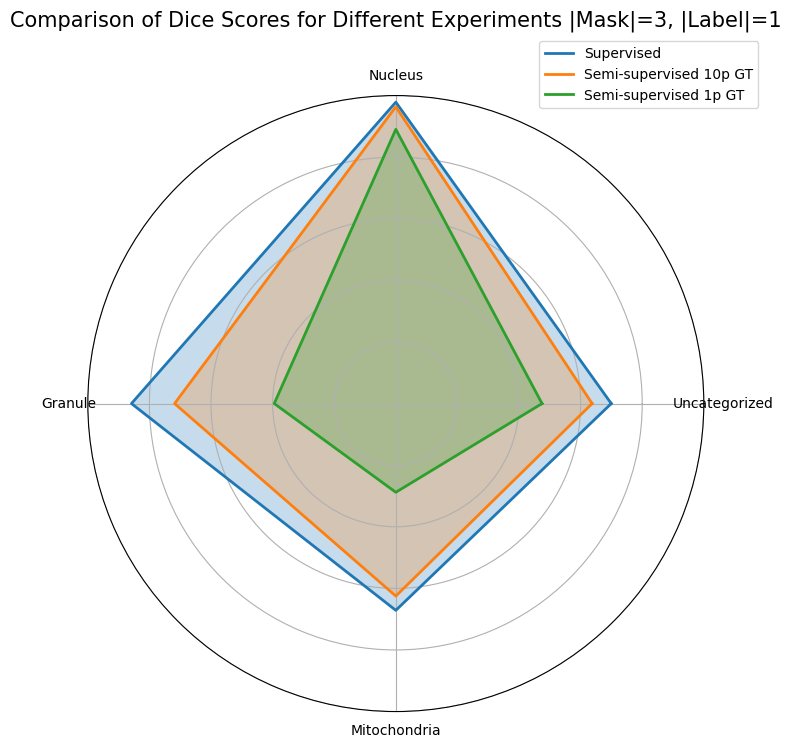

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments |Mask|=3, |Label|=1', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.699523052464229, 0.9785575048732943, 0.8583333333333333, 0.6713615023474179],
[0.6373626373626373, 0.9635627530364372, 0.7183098591549296, 0.625],
[0.47470817120622566, 0.8903225806451613, 0.3946784922394678, 0.2880886426592798]
]
experiment_labels = ['Supervised', 'Semi-supervised 10p GT', 'Semi-supervised 1p GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


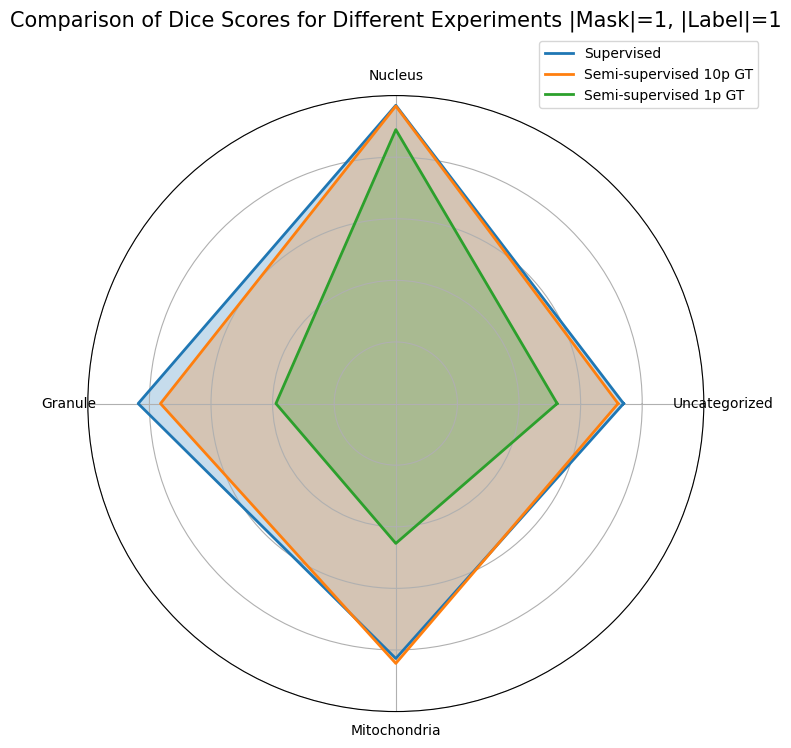

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=2, linestyle='solid', label=experiment_labels[i])
        ax.fill(angles, data, alpha=0.25)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    # Set y-labels and limits
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)  # Assuming dice scores are between 0 and 1

    # Add a title and legend
    plt.title('Comparison of Dice Scores for Different Experiments |Mask|=1, |Label|=1', size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()

# Example data
classes = ['Uncategorized', 'Nucleus', 'Granule', 'Mitochondria']
experiments_data = [
[0.7394957983193278, 0.9683794466403162, 0.8365180467091295, 0.8277310924369747],
[0.7216828478964401, 0.9659318637274549, 0.7640449438202247, 0.8436213991769548],
[0.5238095238095238, 0.8893709327548807, 0.38923395445134573, 0.4540229885057471]
]
experiment_labels = ['Supervised', 'Semi-supervised 10p GT', 'Semi-supervised 1p GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)
